In [141]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn.model_selection as model_selection
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD
from numpy import newaxis
import keras
from keras import backend as K
from sklearn.metrics import classification_report
import tensorflow as tf
import io
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling1D

In [142]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [143]:
import nltk
import os
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
os.chdir('../10_Data/20_Extracted Tweets/15_2018 Test')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../10_Data/20_Extracted Tweets/15_2018 Test'

In [232]:
df1 = pd.read_csv('Earthquake_TREC_2018_test.csv')
df2 = pd.read_csv('Floods_TREC_2018_test.csv')

In [233]:
'''
    Combining all into one big data frame
'''
df = pd.DataFrame()
df['Tweet'] = pd.concat([df1['Tweet'] , df2['Tweet']])
df['Priority'] = pd.concat([df1['Priority'] , df2['Priority']])


In [234]:
df_low = df[df['Priority'] == 'Low'].sample(51)
df_crit = df_c[df_c['Priority'] == 'Critical']
df_c = pd.concat([df_low, df_crit])
df_c = shuffle(df_c)

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [243]:
df_c = pd.read_csv('Ultimate_Dataframe_TREC_2018_Test.csv')
df_c = shuffle(df_c)

In [244]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(df_c):
    t = []
    for element in df_c['Priority']:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
        
    t = np.array(t)
    df_c['Target'] = t

    df_c['Target'] = df_c['Target'].astype('category')
    t = df_c['Target']
    del df_c['Target']
    return (t)

t = to_categorical(df_c)

In [245]:
'''
    Creating a function to input lemmatized text to possibly another function that outputs the tfidf in a csv format.
    We could also simply use the output from this funtion in an tfidf format (no csv) and train a model.
'''
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    token_array = []
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()
    stem = PorterStemmer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(' '.join(element))
        
    return (lemmatized_array_join)


In [246]:
'''
  We tokenize the lemmatized tweets to then do word embeddings
'''
l = preProcess(df_c)

all_words = []

for tweet in l:
    tokenize_word = word_tokenize(tweet)
    for word in tokenize_word:
        all_words.append(word)
'''
    Getting the unique words out
'''
unique_words = set(all_words)

In [247]:
'''
    Getting embedded sentences
'''
vocab_length = len(unique_words)

embedded_sentences = [one_hot(tweet, vocab_length) for tweet in l]

In [248]:
'''
    Making the size of all embeddings equal to the longest one
'''
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(l, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

In [258]:
'''
    Model Paramters
'''
model = keras.Sequential()
model.add(Embedding(vocab_length, 8, input_length=padded_sentences.shape[1]))
model.add(Flatten())
#model.add(GlobalAveragePooling1D())
#model.add(Dense(1024, activation = 'relu'))
#model.add(Dense(512, activation = 'relu'))
#model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'softmax'))


model.summary()


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 59, 8)             320968    
_________________________________________________________________
flatten_7 (Flatten)          (None, 472)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 473       
Total params: 321,441
Trainable params: 321,441
Non-trainable params: 0
_________________________________________________________________


In [259]:
'''
    Compile and fit model
'''
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(padded_sentences, t, batch_size=256, epochs=10, validation_split=0.4, shuffle = True)

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9519 samples, validate on 6346 samples
Epoch 1/10
9519/9519 [==============================] - 1s 98us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 2/10
9519/9519 [==============================] - 1s 70us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 3/10
9519/9519 [==============================] - 1s 65us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 4/10
9519/9519 [==============================] - 1s 62us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 5/10
9519/9519 [==============================] - 1s 65us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 6/10
9519/9519 [==============================] - 1s 64us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 0.0093
Epoch 7/10
9519/9519 [==============================] - 1s 70us/step - loss: 15.2205 - acc: 0.0074 - val_loss: 15.1075 - val_acc: 

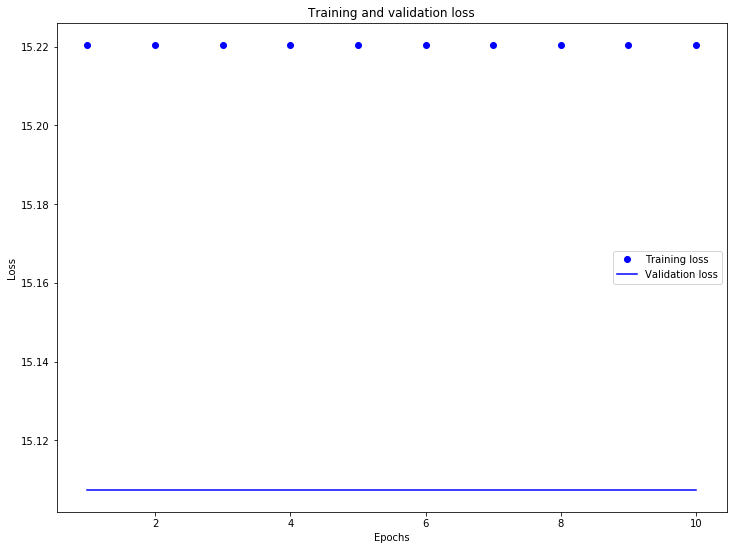

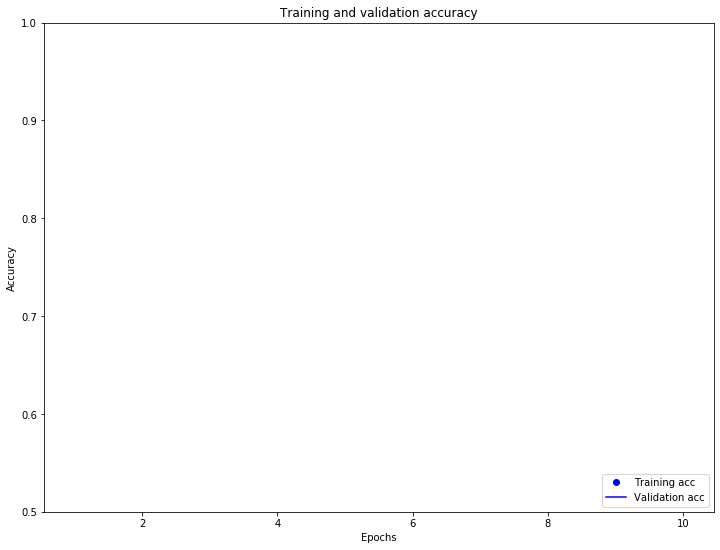

In [256]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [257]:
padded_sentences

array([[38688, 10811,   735, ...,     0,     0,     0],
       [27898, 11425, 25043, ...,     0,     0,     0],
       [26489, 17257, 21457, ...,     0,     0,     0],
       ...,
       [10498,   457, 36474, ...,     0,     0,     0],
       [  841, 18028,  2676, ...,     0,     0,     0],
       [26489, 29695, 32827, ...,     0,     0,     0]])

In [188]:
padded_sentences.shape[1]


34